# Imports and helpers

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

from moabsim_old import MoabEnvOld
from moab_env import MoabEnv as MoabEnvNew

pygame 2.1.2 (SDL 2.0.18, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def uniform_circle(r):
    """Sample a point uniformly inside a circle with radius r."""
    angle = np.random.uniform(-np.pi, np.pi)

    # If we were to uniformly sample magnitude, points would be concentrated
    # more closer to the center, so we need to sample magnitudes scaled to
    # make everything evenly distributed
    unit_circle_mag = np.random.uniform(0, 1)
    unit_circle_mag = 1 - unit_circle_mag**2  # 1 - r^2
    mag = unit_circle_mag * r

    return mag * np.sin(angle), mag * np.cos(angle)

# Controllers

In [3]:
def pid_controller(
    Kp=75,  # Proportional coefficient
    Ki=0.5,  # Integral coefficient
    Kd=45,  # Derivative coefficient
    # Kp=3.41, Ki=0.02266, Kd=20.46,
    **kwargs
):
    sum_x, sum_y = 0, 0

    def next_action(x, y, vel_x, vel_y):
        nonlocal sum_x, sum_y
        sum_x += x
        sum_y += y

        action_x = Kp * x + Ki * sum_x + Kd * vel_x
        action_y = Kp * y + Ki * sum_y + Kd * vel_y

        action = np.array([-action_y, action_x])  # Match order of old sim

        # Use actions between -1 and +1 instead of degrees
        action /= -22
        pitch, roll = np.clip(action, -1, 1)

        return pitch, roll

    return next_action

# Comapre variations of old Moab sim and new Moab sim
- With instant plate angles (new pitch and roll is whatever the NN sets it to)
- With linear acceleration of the plate angles (don't instantly set new pitch and roll, let it take some time...)
- Quantization of plate angles to nearest angle

1
1
1
1
1
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
0
0
0
1
0
0
0
1
0
0
1
0
0
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
1
1
1
1
1
1
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


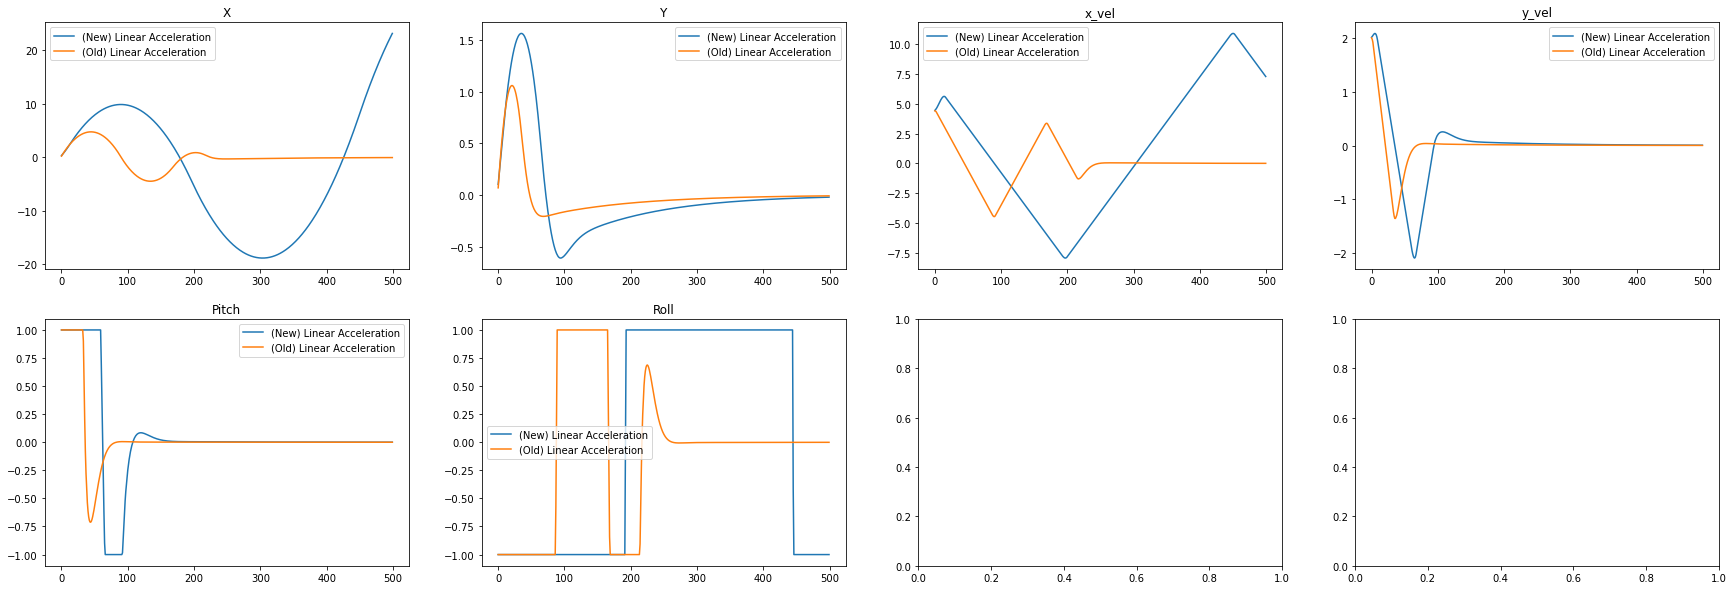

In [4]:
# fmt: off
n = 500

plate_radius = 0.1125
max_init_vel = 5.0
init_x, init_y = uniform_circle(plate_radius * 0.6)
init_x_vel, init_y_vel = uniform_circle(max_init_vel)

config = {
    "initial_roll": 0.0,
    "initial_pitch": 0.0,
    "initial_x": init_x,
    "initial_y": init_y,
    "initial_vel_x": init_x_vel,
    "initial_vel_y": init_y_vel,
    "dt": 0.0333,  # in s, 33.3ms
    "jitter": 0.0,  # in s, +/- 4ms
    "gravity": 9.81,  # m/s^2, Earth: there's no place like it.
    "plate_radius": 0.1125,  # m, Moab: 112.5mm radius
    "ball_mass": 0.0027,  # kg, Ping-Pong ball: 2.7g
    "ball_radius": 0.02,  # m, Ping-Pong ball: 20mm
    "ball_shell": 0.0002,  # m, Ping-Pong ball: 0.2
}

options = [
    # {"name": "(New) Instant Position", "env": MoabEnvNew, "kwargs": {"linear_acceleration_servos": False, "quantize": False}},
    # {"name": "(Old) Instant Position", "env": MoabEnvOld, "kwargs": {"linear_acceleration_servos": False, "quantize": False}},
    {"name": "(New) Linear Acceleration", "env": MoabEnvNew, "kwargs": {"linear_acceleration_servos": True, "quantize": False}},
    {"name": "(Old) Linear Acceleration", "env": MoabEnvOld, "kwargs": {"linear_acceleration_servos": True, "quantize": False}},
    # {"name": "(New) Quantized Angles", "env": MoabEnvNew, "kwargs": {"linear_acceleration_servos": False, "quantize": True}},
    # {"name": "(Old) Quantized Angles", "env": MoabEnvOld, "kwargs": {"linear_acceleration_servos": False, "quantize": True}},
    # {"name": "(New) All mods", "env": MoabEnvNew, "kwargs": {"linear_acceleration_servos": True, "quantize": True}},
    # {"name": "(Old) All mods (OG sim)", "env": MoabEnvOld, "kwargs": {"linear_acceleration_servos": True, "quantize": True}},
]
state_hists = {}

for opt in options:
    # Run sim with specified options
    env = opt["env"](**opt["kwargs"])
    env.reset(config=config)
        
    state_hists[opt["name"]] = np.zeros((n, 6))
    controller = pid_controller()
    state = init_x, init_y, init_x_vel, init_y_vel

    for i in range(n):
        action = pitch, roll = controller(*state)
        state, info, _, _ = env.step(np.asarray(action))
        x, y, x_vel, y_vel = state
        state_hists[opt["name"]][i, :] = x, y, x_vel, y_vel, pitch, roll


# Ploty thingy
fig, axes = plt.subplots(2, 4, figsize=(30, 10))

for opt in options:
    axes[0][0].plot(np.arange(n), state_hists[opt["name"]][:, 0], label=opt["name"])
    axes[0][1].plot(np.arange(n), state_hists[opt["name"]][:, 1], label=opt["name"])
    axes[0][2].plot(np.arange(n), state_hists[opt["name"]][:, 2], label=opt["name"])
    axes[0][3].plot(np.arange(n), state_hists[opt["name"]][:, 3], label=opt["name"])
    axes[1][0].plot(np.arange(n), state_hists[opt["name"]][:, 4], label=opt["name"])
    axes[1][1].plot(np.arange(n), state_hists[opt["name"]][:, 5], label=opt["name"])

axes[0][0].set_title("X")
axes[0][0].legend()
axes[0][1].set_title("Y")
axes[0][1].legend()
axes[0][2].set_title("x_vel")
axes[0][2].legend()
axes[0][3].set_title("y_vel")
axes[0][3].legend()
axes[1][0].set_title("Pitch")
axes[1][0].legend()
axes[1][1].set_title("Roll")
axes[1][1].legend()

plt.show()
# fmt: on